<a href="https://colab.research.google.com/github/rpdahxn/HandsOnML/blob/main/14_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

흑백 이미지와 컬러 이미지 출력을 위한 유틸리티 함수

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## 14.2 합성곱 층

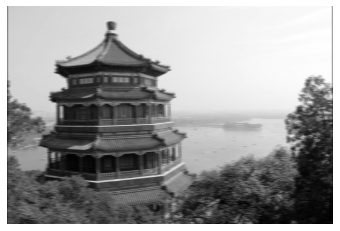

In [3]:
import numpy as np 
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china,flower])
batch_size, height, width, channels = images.shape

# 2개의 필터
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1  # 수직선 , 0부터 6중 3이 중간값
filters[3, :, :, 1] = 1  # 수평선

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

plt.imshow(outputs[0, :, :, 1], cmap = 'gray')  # 첫 번째 이미지의 두 번째 특성맵을 그린다.
plt.axis("off")
plt.show()

In [ ]:
filters.shape

(7, 7, 3, 2)

In [ ]:
images.shape

(2, 427, 640, 3)

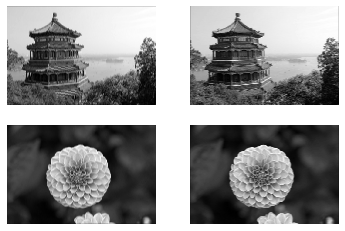

In [ ]:
for image_index in (0, 1):
  for feature_map_index in (0, 1):
    plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
    plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

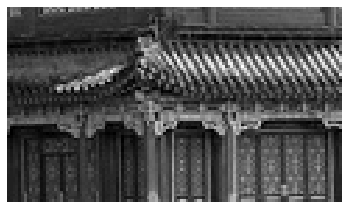

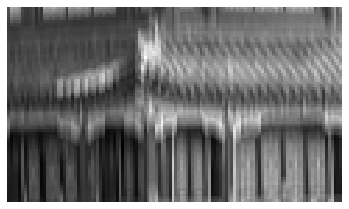

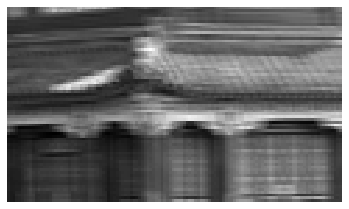

In [ ]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

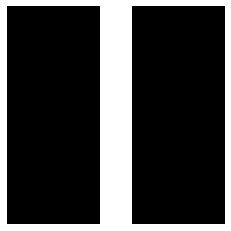

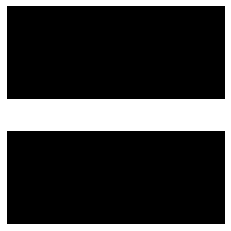

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [ ]:
# 합성곱 층
conv = keras.layers.Conv2D(filters = 2, kernel_size = 7, strides = 1,  # 2개의 필터(7x7)
                           padding = "SAME", activation = "relu", input_shape = outputs.shape)

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

출력은 4D 텐서 (배치 크기, 높이, 너비, 채널)  
2: 2개의 이미지 입력, 427, 640: 출력 특성맵의 높이와 너비, 2: 입력 이미지마다 2개의 특성맵이 출력된다.  
필터는 초기에 랜덤하게 초기화된다.

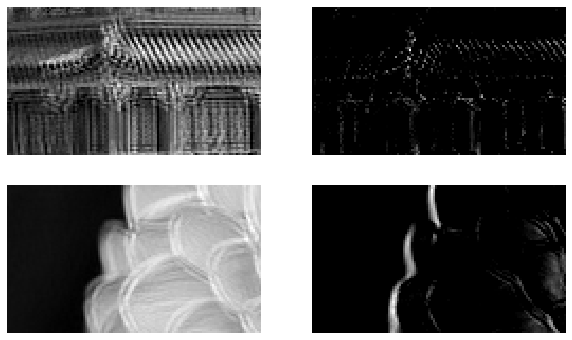

In [ ]:
plt.figure(figsize = (10, 6))
for image_index in (0, 1):
  for feature_map_index in (0, 1):
    plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
    plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

두 번째 필터는 에지를 감지한 것처럼 보인다.  
원한다면 원하는 필터를 지정하고 편향을 0으로 지정할 수도 있지만 합성곱 층이 훈련하는 동안 적절한 필터와 편향을 학습기 때문에 수동으로 필터와 편향을 지정할 필요는 거의 없다.

In [ ]:
conv.set_weights([filters, np.zeros(2)])  # 내가 원하는 필터로 지정, 편향은 0으로 설정

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

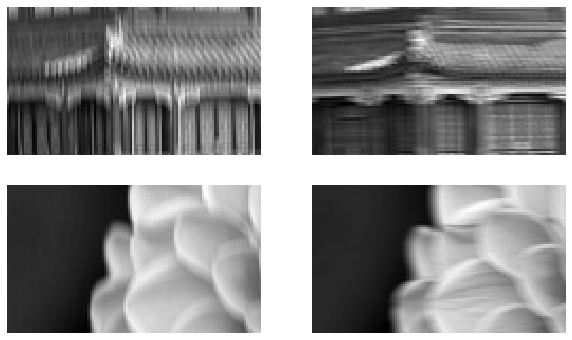

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

**VALID vs SAME 패딩**

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [ ]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [ ]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 합니다.
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사합니다.
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## 14.7 풀링 층  
최대 풀링

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size = 2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

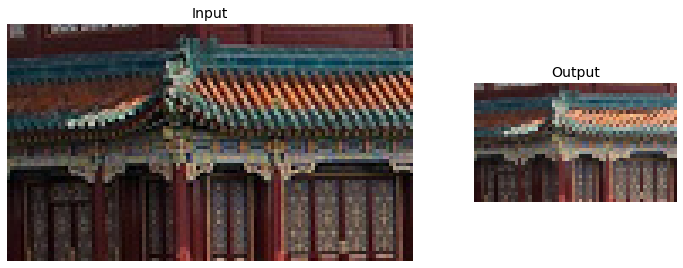

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

깊이 방향(depth-wise) 풀링

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

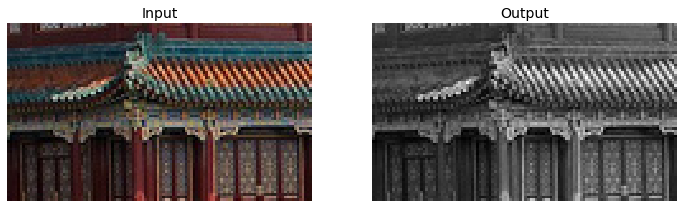

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

평균 풀링

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size = 2)

In [ ]:
output_avg = avg_pool(cropped_images)

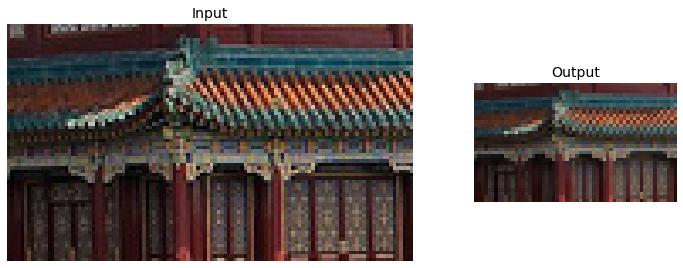

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

전역 평균 풀링

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis = [1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

## 14.4 CNN 구조

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_mean = X_train.mean(axis = 0, keepdims = True)
X_std = X_train.std(axis = 0, keepdims = True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size = 3, activation = 'relu', padding = 'SAME')

model = keras.models.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size = 2),  # 풀링 크기 2로 공간 방향 차원을 절반으로 줄인다.
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    keras.layers.MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 10, activation = 'softmax')
])

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 45s 22ms/step - loss: 0.7270 - accuracy: 0.7474 - val_loss: 0.3940 - val_accuracy: 0.8654
Epoch 2/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.4324 - accuracy: 0.8551 - val_loss: 0.3599 - val_accuracy: 0.8714
Epoch 3/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.3669 - accuracy: 0.8761 - val_loss: 0.3184 - val_accuracy: 0.8808
Epoch 4/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.3371 - accuracy: 0.8859 - val_loss: 0.3034 - val_accuracy: 0.8928
Epoch 5/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3142 - accuracy: 0.8931 - val_loss: 0.2785 - val_accuracy: 0.8982
Epoch 6/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.2921 - accuracy: 0.9006 - val_loss: 0.2834 - val_accuracy: 0.8890
Epoch 7/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.2806 - accuracy: 0.9046 - val_loss: 0.2726 -

### 14.4.5 ResNet  
ResNet-34

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

## 14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

In [2]:
model = keras.applications.resnet50.ResNet50(weights = 'imagenet')

102981632/102967424 [==============================] - 1s 0us/step


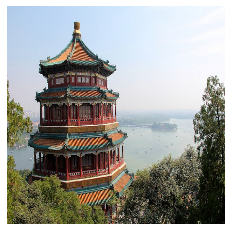

In [7]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


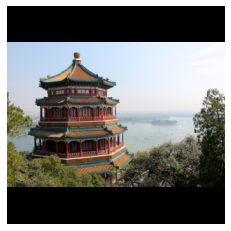

In [8]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias = True)
plot_color_image(images_resized[0])

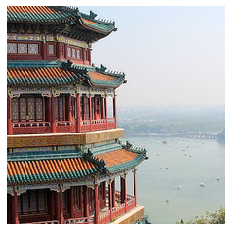

In [9]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

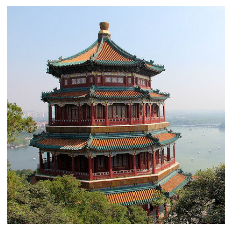

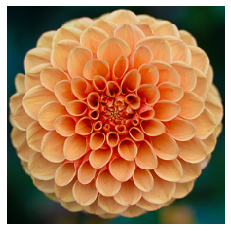

In [10]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [12]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [13]:
Y_proba.shape

(2, 1000)

In [14]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top = 3)
for image_index in range(len(images)):
  print("Image #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print("   {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
  print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
   n03877845 - palace       43.39%
   n02825657 - bell_cote    43.07%
   n03781244 - monastery    11.69%

Image #1
   n04522168 - vase         53.96%
   n07930864 - cup          9.52%
   n11939491 - daisy        4.97%



## 14.7 사전훈련된 모델을 사용한 전이 학습